In [1]:
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from scipy import sparse
import odl

from ray_transforms import get_ray_trafo, get_static_ray_trafo
from test_model_functions_swaped import get_net_corected_operator
from Iteration_Steps import get_grad_desc_step
# import random
from util import hide_axis
from conf import config
from select_model_type_matrix import select_fwd_model_type,select_adj_model_type
from util import get_op,Mat,plots,hide_axis,rand_shift_params,error_for_y

In [2]:
def obj_func(op,y,lam,R,x):
    return 1/(2)*np.linalg.norm((op(x)-y).reshape(y.size),2)**2+lam*R(x)

def im_norm(x):
    if type(x) is odl.discr.discr_space.DiscretizedSpaceElement:
        x= x.asarray()
    x = x.reshape(x.size)
    return np.linalg.norm(x,2)

def sp(a,b):
    return a.reshape(a.size)@b.reshape(b.size)

def get_shift(shift_params):
    def shift(angle):
        u_shift = 0
        v_shift = 0
        for i in range(shift_params.shape[0]):
            u_shift = shift_params[i,0,0]*np.sin(shift_params[i,0,1]*angle+shift_params[i,0,2])
            v_shift = shift_params[i,1,0]*np.sin(shift_params[i,1,1]*angle+shift_params[i,1,2])
        return np.array([u_shift,v_shift]).T
    return shift 

In [3]:
gpu_idx = 0
device = f"cuda:{gpu_idx}" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
import astra
astra.set_gpu_index(gpu_idx)

Using cuda:0 device


In [4]:
c = config('run_20220912_matrix_ISTA')
path = c.path
print(c.note)

ISTA paper just one operator maybe now more then blurring


In [5]:
tp = np.load(file='phantoms/test_phantoms_64_1.npy')
p = tp[0,:,:]
p.shape

(64, 64)

In [6]:
rand_shift_dict = dict()
rand_shift_dict.update({"num_params":2})
rand_shift_dict.update({"amp_range":[0.03,0.05]})
rand_shift_dict.update({"freq_range":c.freq_range})
rand_shift_dict.update({"freq_shift_range":c.freq_shift_range})
rand_shift_dict
shift = get_shift(rand_shift_params(**rand_shift_dict))


In [7]:
impl = 'astra_cpu'

# shift_params_list =list()
# shift_params_list.append(np.array([[[0,1000,0],[0.1,1000,0]]]))
# shift_params_list.append(np.array([[[0,1000,0],[0.01,1000,0]]]))
# shift_params_list.append(np.array([[[0.1,1000,0],[0.1,1000,0]]]))
# shift_params_list.append(np.array([[[0.1,1000,0],[0.1,1000,500]]]))
# shift_params_list.append(np.array([[[0.1,2000,0],[0.1,2000,0]]]))
# shift_params_list = c.shift_params_list
# shift = get_shift(c.shift_params)
# shift = get_shift(shift_params_list[0])
ray_trafo = get_ray_trafo(c.x_res, c.y_res,c.num_angles,c.detector_points,DET_SHIFT=shift,detector_len=2,impl=impl)
domain = ray_trafo.domain
adj_domain = ray_trafo.adjoint.domain
# A = Mat(ray_trafo)
# def ray_trafo(x):
#     return domain.element((A@x.reshape(64**2)).reshape(64,64))
# def ray_trafo_adjoint(x):
#     return adj_domain.element((A.T@x.reshape(64**2)).reshape(64,64))
# ray_trafo.adjoint = ray_trafo_adjoint

static_ray_trafo = get_ray_trafo(c.x_res, c.y_res,c.num_angles,c.detector_points,detector_len=2,impl=impl)

# op_norm = ray_trafo.norm('estimate')

adj_norm_coef = im_norm(np.ones(64**2))/(ray_trafo.adjoint.domain.one()).norm()
norm_coef = im_norm(np.ones(64**2))/(ray_trafo.domain.one()).norm()

fileending = 'png'
doent_show = False
save_path = f'{path}Test/'
if not os.path.isdir(save_path):
    os.makedirs(save_path)

ceep_shift = True

ray_trafo = get_ray_trafo(c.x_res, c.y_res,c.num_angles,c.detector_points,DET_SHIFT=shift,detector_len=2)
# if c.load_A_s and ceep_shift:
#     A_s = sparse.load_npz(c.test_A_s_path)
#     A_s = sparse.load_npz('Matritzen/Test_ray_trafo_64_256_96_100.npz')
#     # A_s = sparse.load_npz('Matritzen/64_64_256_96_1_u_v_shift/ray_trafo_0.npz')
# else:
#     A_s = sparse.csr_matrix(Mat(ray_trafo,c.x_res, c.y_res, c.num_angles, c.detector_points))
A_s = sparse.load_npz('Matritzen/Test_ray_trafo_64_256_96_100.npz')
true_op = get_op(A_s,c.x_res, c.y_res, c.num_angles, c.detector_points)

static_ray_trafo = get_static_ray_trafo(c.x_res, c.y_res,c.num_angles,c.detector_points,detector_len=2)
if c.load_static_A_s:
    A_static_s = sparse.load_npz(c.static_A_s_path)
else:
    A_static_s = sparse.csr_matrix(Mat(static_ray_trafo,c.x_res, c.y_res,c.num_angles,c.detector_points))
static_op = get_op(A_static_s,c.x_res, c.y_res, c.num_angles, c.detector_points)

y = true_op(p)
# c.e_p=0
y_e = error_for_y(y, c.e_p)

In [8]:
rt_norm = np.linalg.norm((A_static_s.T@A_static_s).todense(),2)
rt_norm

2.9103114661964562

In [11]:
1/np.linalg.norm((A_s.T@A_s).todense(),2)

0.34375589375991966

In [9]:
TA_static_s = torch.sparse_csr_tensor(A_static_s.indptr,A_static_s.indices,A_static_s.data,A_static_s.shape,dtype=float)
model = select_fwd_model_type(c,TA_static_s.to_dense().to(device))
AT_static_s = sparse.csr_matrix(A_static_s.T)
TAT_static_s = torch.sparse_csr_tensor(AT_static_s.indptr,AT_static_s.indices,AT_static_s.data,AT_static_s.shape,dtype=float)
adjoint_model = select_adj_model_type(c,TAT_static_s.to_dense().to(device))
a = 'iter_49' #'iter_20'
model.load_state_dict(torch.load(c.model_path + 'model_' + a,map_location=device))
adjoint_model.load_state_dict(torch.load(c.model_path + 'adjoint_model_' + a,map_location=device))
model = model.to(device)
adjoint_model = adjoint_model.to(device)

In [10]:
cor_op = get_net_corected_operator(static_op, model,device = device,swaped=c.forward_swaped)
cor_adj_op = get_net_corected_operator(static_op.adjoint, adjoint_model,device = device,swaped=c.adj_swaped)

In [11]:
# R = odl.solvers.L2Norm(ray_trafo.domain)
# grad_R = R.gradient
# R = lambda x: 0.5*im_norm(x)**2
# grad_R = lambda x: ray_trafo.domain.element(x)
R = odl.solvers.Huber(static_ray_trafo.domain,0.001)
grad_R = R.gradient

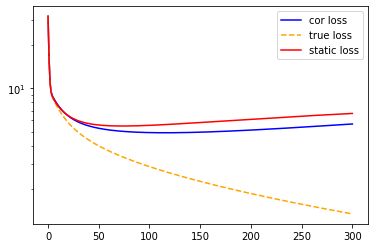

In [12]:
x_0 = static_op.adjoint(y_e)
c.mu = 0.2

def F_cor_abl(x):
    return cor_adj_op(cor_op(x)-y_e)
def F_true_abl(x):
    return true_op.adjoint(true_op(x)-y_e)
def F_static_abl(x):
    return static_op.adjoint(static_op(x)-y_e)
cor_step = get_grad_desc_step(F_cor_abl,c.mu,c.lam,grad_R,c.pos_constraint)  
true_step = get_grad_desc_step(F_true_abl,c.mu,c.lam,grad_R,c.pos_constraint)  
static_step = get_grad_desc_step(F_static_abl,c.mu,c.lam,grad_R,c.pos_constraint)  

X_cor = [x_0]
X_true = [x_0]
X_static = [x_0]
cor_loss = [im_norm(X_cor[-1]-p)]
true_loss = [im_norm(X_true[-1]-p)]
static_loss = [im_norm(X_static[-1]-p)]

num_iterations = 300

for j in range(num_iterations):

    X_cor.append(cor_step(X_cor[-1]))
    X_true.append(true_step(X_true[-1]))
    X_static.append(static_step(X_static[-1]))
    cor_loss.append(im_norm(X_cor[-1]-p))
    true_loss.append(im_norm(X_true[-1]-p))
    static_loss.append(im_norm(X_static[-1]-p))

fig,ax = plt.subplots()
ax.plot(cor_loss,'b',label = 'cor loss')
ax.plot(true_loss,'orange',linestyle='--',label = 'true loss')
ax.plot(static_loss,'r',label = 'static loss')
ax.legend()
ax.set_yscale('log')
plt.show(fig)

In [22]:
from Test_Model import Test
from Iteration_Steps import GD_step
step_op = GD_step(c.mu,c.lam,grad_R)

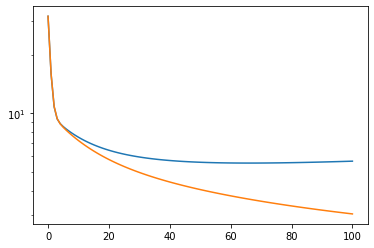

In [23]:
L_Test = lambda x: obj_func(true_op,y_e,c.lam,R,x)
Test_dic_static = Test(step_op,L_Test,true_op,y_e,p,static_op.adjoint(y_e),static_op,static_op.adjoint,c.lam,c.mu,100)
Test_dic_true = Test(step_op,L_Test,true_op,y_e,p,static_op.adjoint(y_e),true_op,true_op.adjoint,c.lam,c.mu,100)
plt.plot(Test_dic_static.get('loss'))
plt.plot(Test_dic_true.get('loss'))
plt.yscale('log')


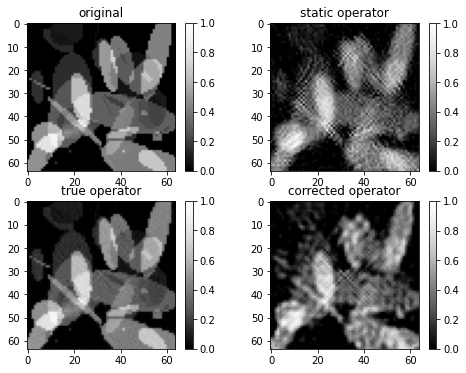

In [24]:
fig,axs = plots(2,2,4/3)
axs[0,0].set_title('original')
im = axs[0,0].imshow(p,cmap = 'Greys_r')
fig.colorbar(im,ax=axs[0,0])
axs[1,0].set_title('true operator')
im = axs[1,0].imshow(X_true[-1],cmap = 'Greys_r')
fig.colorbar(im,ax=axs[1,0])
axs[0,1].set_title('static operator')
im = axs[0,1].imshow(X_static[-1],cmap = 'Greys_r')
fig.colorbar(im,ax=axs[0,1])
axs[1,1].set_title('corrected operator')
im = axs[1,1].imshow(X_cor[-1],cmap = 'Greys_r')
fig.colorbar(im,ax=axs[1,1])
plt.show(fig)


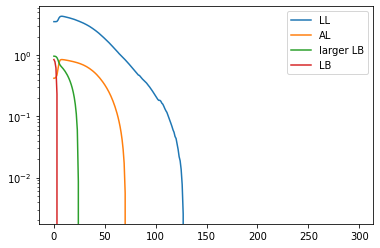

In [25]:
LL = np.zeros(len(X_cor)-1) #L(x)-L(x_Theta) 
D = np.zeros(len(X_cor)-1)
AL = np.zeros(len(X_cor)-1) #Alignement
FwL = np.zeros(len(X_cor)-1) #forward Loss
AdL = np.zeros(len(X_cor)-1) #adjoint Loss
LB = np.zeros(len(X_cor)-1) #Lowerbound
larger_LB = np.zeros(len(X_cor)-1) #Lowerbound


L = lambda lam,x :obj_func(true_op,y_e,lam,R,x)

for i,x_Theta_p in enumerate(X_cor[1:]):
    x = X_cor[i]
    grx = c.lam * grad_R(x).asarray()
    D[i] = im_norm(F_true_abl(x)+grx)**2#im_norm(F_cor_abl(x)+grx)
    # D[i] = im_norm(F_cor_abl(x)+grx)**2#im_norm(F_true_abl(x)+grx)
    LL[i] = (L(c.lam,x)-L(c.lam,x_Theta_p))
    AL[i] = sp(F_true_abl(x_Theta_p)+grx,F_cor_abl(x)+grx)
    FwL[i] = im_norm(true_op(x)-cor_op(x))
    r = cor_op(x)-y_e
    AdL[i] = im_norm(true_op.adjoint(r)-cor_adj_op(r))
    LB[i] = 1-(rt_norm*FwL[i]+AdL[i])/im_norm(F_cor_abl(x)+grx)
    h = im_norm(true_op.adjoint(true_op(x)-cor_op(x)))
    larger_LB[i] = 1-(h+AdL[i])/im_norm(F_cor_abl(x))
    print
plt.plot(LL/(D*c.mu**2),label='LL')
plt.plot(AL/D,label='AL')
plt.plot(larger_LB,label='larger LB')
plt.plot(LB,label='LB')
plt.yscale('log')
plt.legend()

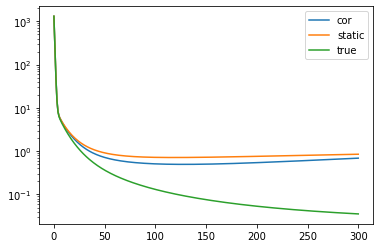

In [26]:
true_L_graphs = np.zeros((len(X_cor),3))
for i in range(len(X_cor)):
    true_L_graphs[i,0] = L(c.lam,X_cor[i])
    true_L_graphs[i,1] = L(c.lam,X_static[i])
    true_L_graphs[i,2] = L(c.lam,X_true[i])
plt.plot(true_L_graphs)
plt.legend(['cor','static','true'])
plt.yscale('log')

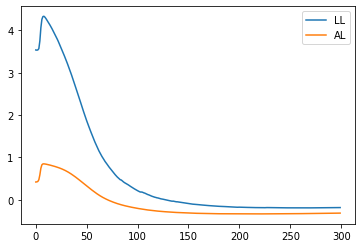

In [27]:
plt.plot(LL/(D*c.mu**2),label='LL')
plt.plot(AL/D,label='AL')
# plt.plot(larger_LB,label='larger LB')
# plt.plot(LB,label='LB')
# plt.yscale('log')
plt.legend()

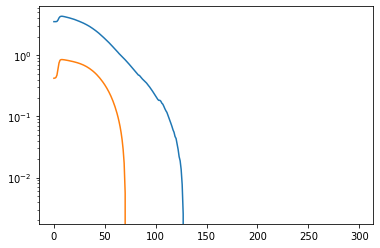

In [36]:
plt.plot(LL/(c.mu**2)/D,label='LL')
plt.plot(AL/D,label='AL')
plt.yscale('log')

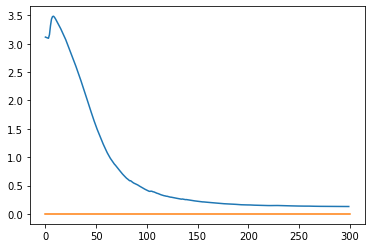

In [31]:
plt.plot((LL/c.mu**2-AL)/D)
plt.plot([0,300],[0,0])

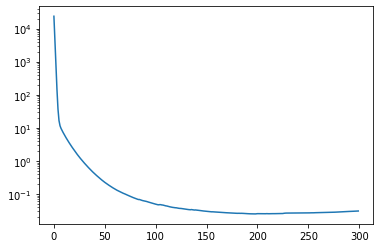

In [30]:
plt.plot((LL/c.mu**2-AL))
plt.yscale('log')

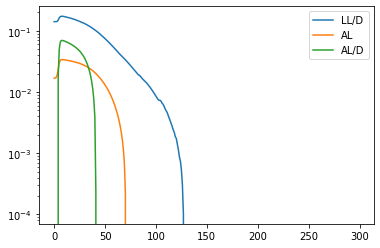

In [35]:
plt.plot(LL/D,label='LL/D')
plt.plot(c.mu**2*AL/D,label='AL')
plt.plot(c.mu*(AL/D-0.5),label='AL/D')
# plt.plot(larger_LB,label='larger LB')
# plt.plot(LB,label='LB')
# plt.ylim([-1,0.2])
plt.yscale('log')
plt.legend()

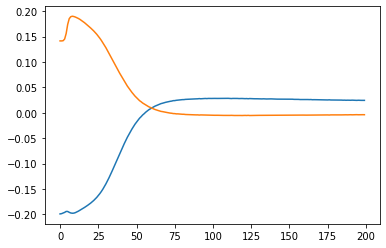

In [70]:
plt.plot(-AL/D*c.mu)
plt.plot(LL/D)

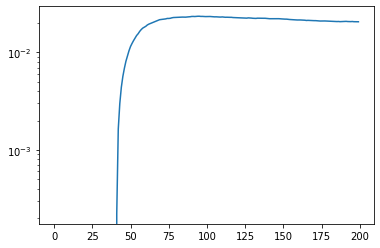

In [69]:
plt.plot((LL-AL*c.mu)/D)
plt.yscale('log')

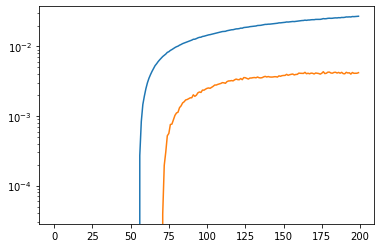

In [56]:
plt.plot(-c.mu*AL)
plt.plot(-LL)
plt.yscale('log')

In [142]:
(LL>=AL).all(),(AL>=larger_LB).all(),(larger_LB>=LB).all()

(False, True, True)

In [143]:
(LL/c.mu**2>=AL).all()

True

In [126]:
1/c.mu**2

24.999999999999996

In [29]:
AL >= 0

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False,

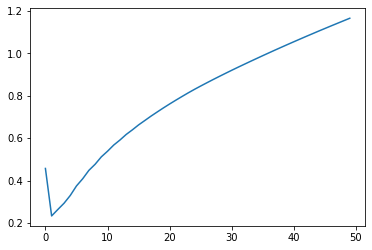

In [42]:
plt.plot(FwL)

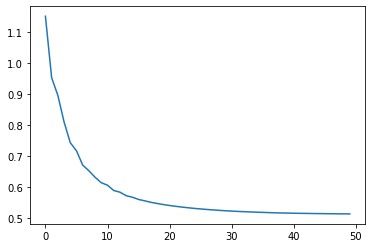

In [43]:
plt.plot(AdL)

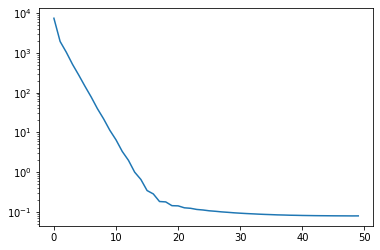

In [44]:
plt.plot(D)
plt.yscale('log')

plt.plot(AdL)

In [15]:
vars(c)

{'run_name': 'run_20220718_matrix_GD',
 'path': 'runs/run_20220718_matrix_GD/',
 'f': <_io.TextIOWrapper name='runs/run_20220718_matrix_GD/conf_dict.json' mode='r' encoding='UTF-8'>,
 'd': {'note': 'run on GD just unet models',
  'run_name': 'run_20220718_matrix_GD',
  'path': 'runs/run_20220718_matrix_GD/',
  'fileending': 'svg',
  'phantoms_path': 'phantoms/',
  'train_phantom_path': 'phantoms/train_phantoms_64_1000.npy',
  'val_phantom_path': 'phantoms/validation_phantoms_64_10.npy',
  'test_phantom_path': 'phantoms/test_phantoms_64_1.npy',
  'doent_show': True,
  'model_path': 'runs/run_20220718_matrix_GD/models/',
  'test_the_model': False,
  'device': 'check',
  'start_iteration': 0,
  'num_iterations': 20,
  'num_epoch_list': [10,
   10,
   10,
   10,
   10,
   10,
   10,
   10,
   10,
   10,
   10,
   10,
   10,
   10,
   10,
   10,
   10,
   10,
   10,
   10],
  'num_adj_epoch_list': [10,
   10,
   10,
   10,
   10,
   10,
   10,
   10,
   10,
   10,
   10,
   10,
   10,
   10

In [6]:
l = np.array([1,2,3,4])

In [8]:
l[[1,3]]

array([2, 4])

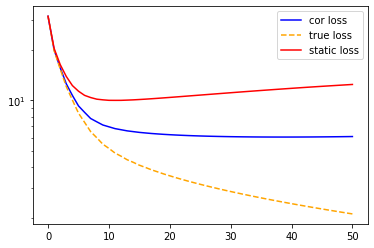

In [47]:
fig,ax = plt.subplots()
ax.plot(cor_loss,'b',label = 'cor loss')
ax.plot(true_loss,'orange',linestyle='--',label = 'true loss')
ax.plot(static_loss,'r',label = 'static loss')
ax.legend()
ax.set_yscale('log')
plt.show(fig)